# Security & Privacy (CC2009) - 2023/2024

## ASSIGNMENT #1: Performance Benchmarking of Cryptographic Mechanisms

### Due date: March 22, 23:59
### Grading: Assignment #1 is worth 2 points

In this exercise you should measure the time AES, RSA and SHA take to process files of different sizes, using a
python implementation of the encryption/description and hash mechanisms.
Some notes:
- You should measure the time of cryptographic operations/algorithms only, not including the time for generation
of files and others side aspects.
- If you use padding, this may affect the results specially for small file sizes

-------------------------------------------------------------------------------------------------------------------------------------

In [52]:
import os
import string
import timeit
import hashlib
import matplotlib.pyplot as plt
import numpy as np
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives.asymmetric import rsa
from cryptography.hazmat.primitives import serialization
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.asymmetric import padding

-------------------------------------------------------------------------------------------------------------------------------------

A. Generate random text files with the following sizes:
- For AES (in bytes): 8, 64, 512, 4096, 32768, 262144, 2097152 
- For SHA (in bytes): 8, 64, 512, 4096, 32768, 262144, 2097152 
- For RSA (in bytes): 2, 4, 8, 16, 32, 64, 128


In [53]:
# Sizes in bytes
file_sizes_aes = [8, 64, 512, 4096, 32768, 262144, 2097152]
file_sizes_sha = [8, 64, 512, 4096, 32768, 262144, 2097152]
file_sizes_rsa = [2, 4, 8, 16, 32, 64, 128]

def generate_random_text_file(size_bytes):
    return os.urandom(size_bytes)

# Generate random text files for aes
for size in file_sizes_aes:
    with open(f"aes_{size}.txt", "wb") as f:
        f.write(generate_random_text_file(size))

# Generate random text files for sha
for size in file_sizes_sha:
    with open(f"sha_{size}.txt", "wb") as f:
        f.write(generate_random_text_file(size))

# Generate random text files for rsa
for size in file_sizes_rsa:
    with open(f"rsa_{size}.txt", "wb") as f:
        f.write(generate_random_text_file(size))

-------------------------------------------------------------------------------------------------------------------------------------

B. Encrypt and decrypt all these files using AES. Employ a key of 256 bits. Measure the time it takes to encrypt
and decrypt each of the files. To do this, you might want to use the python module timeit. Make sure to produce statistically significant results.

- Do results change if you run a fixed algorithm over the same file multiple times? 
- What if you run an algorithm over multiple randomly generated files of fixed size?

We chose the CFB mode to apply in AES because it's faster than the others. 

To analyze the AES perfomance at its core, we created 3 functions that plot different types of data. 

Firstly, after coding the encrpyption and the decryption algorithms for AES, we created a function "Measure_Avg_Time_AES" to measure the average time it takes for the algorithms to encrypt and decrypt the files for each size

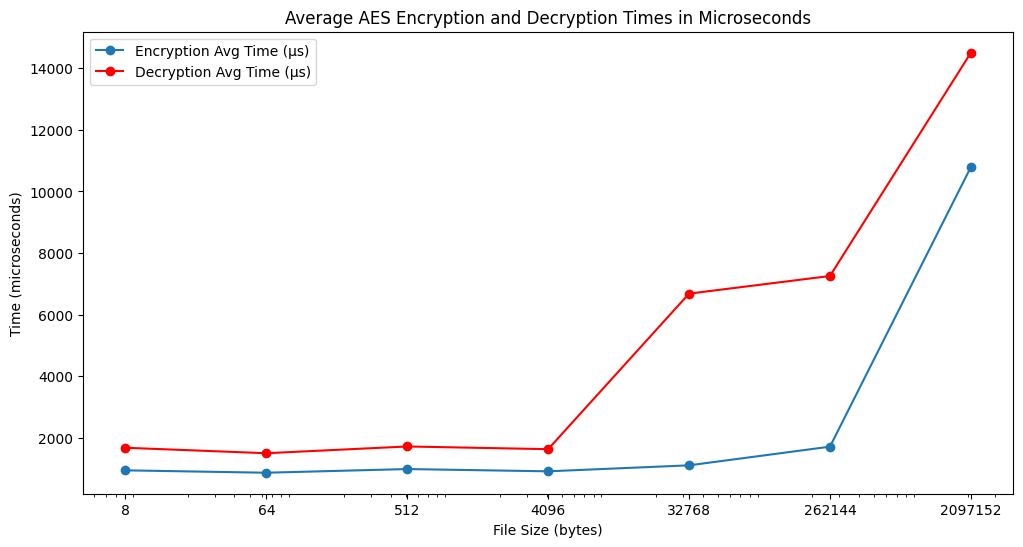

In [54]:
def encrypt_file_aes(input_file, output_file, key, iv):
    with open(input_file, 'rb') as f:
        plaintext = f.read()
    
    cipher = Cipher(algorithms.AES(key), modes.CFB(iv), backend=default_backend())
    encryptor = cipher.encryptor()
    encrypted_data = encryptor.update(plaintext) + encryptor.finalize()
    with open(output_file, 'wb') as f:
        f.write(encrypted_data)

def decrypt_file_aes(input_file, key, iv):
    with open(input_file, 'rb') as f:
        encrypted_data = f.read()
    cipher = Cipher(algorithms.AES(key), modes.CFB(iv), backend =default_backend())
    decryptor = cipher.decryptor()
    decrypted_data = decryptor.update(encrypted_data) + decryptor.finalize()


def Measure_Avg_Time_AES(file_sizes_aes):
    encryption_times_avg = []
    decryption_times_avg = []
    num_runs = 200
    key = os.urandom(32)
    iv = os.urandom(16)
    for size in file_sizes_aes:
        if size in [8,64,512]:
            num_runs = 1500
        encryption_times = []
        decryption_times = []
        for _ in range(num_runs):
            input_file = f"aes_{size}.txt"
            encrypted_file = f"aes_{size}_encrypted.txt"
            
            # Measure encryption time
            encryption_time = timeit.timeit(lambda: encrypt_file_aes(input_file, encrypted_file, key, iv), number=1)
            encryption_times.append(encryption_time)
            
            # Measure decryption time
            decryption_time = timeit.timeit(lambda: decrypt_file_aes(encrypted_file, key, iv), number=1)
            decryption_times.append(decryption_time)
        
        # Calculate average
        encryption_times_avg.append(sum(encryption_times) / num_runs)
        decryption_times_avg.append(sum(decryption_times) / num_runs)

    # Convert seconds to microseconds by multiplying by 1,000,000
    encryption_times_us = [t * 1e6 for t in encryption_times_avg]
    decryption_times_us = [t * 1e6 for t in decryption_times_avg]

    # Plotting averages
    plt.figure(figsize=(12, 6))
    plt.plot(file_sizes_aes, encryption_times_us, '-o', label='Encryption Avg Time (µs)')
    plt.plot(file_sizes_aes, decryption_times_us, '-o', label='Decryption Avg Time (µs)', color='red')
    plt.xlabel('File Size (bytes)')
    plt.ylabel('Time (microseconds)')
    plt.xscale('log')

    # Adjust the x-ticks to show file sizes in bytes
    plt.xticks(file_sizes_aes, labels=[str(size) for size in file_sizes_aes])

    # Since we're dealing with a larger range, matplotlib's automatic tick selection should work fine
    # If you want to set your own y-ticks, you can calculate and set them as needed

    plt.title('Average AES Encryption and Decryption Times in Microseconds')
    plt.legend()

    plt.show()


Measure_Avg_Time_AES(file_sizes_aes)



Secondly, we create a function "Measure_Time_AES_Multiple_Times" that runs 100 times the same encrprytion and decryption algorithms over the each file.

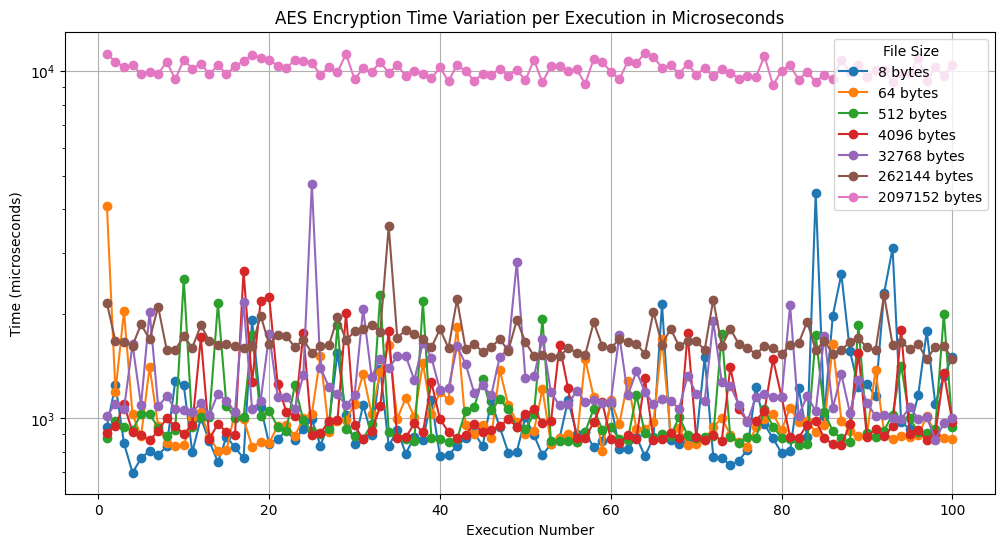

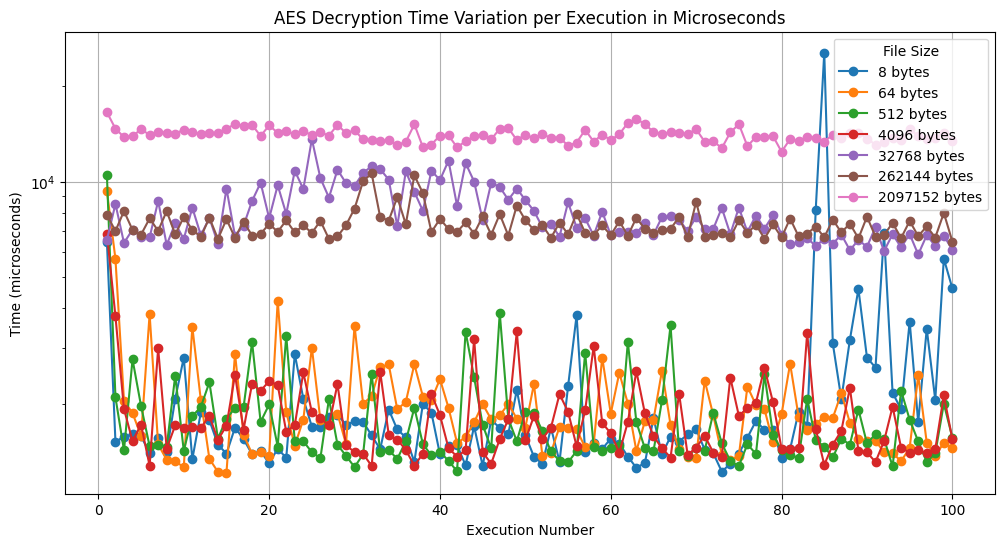

In [55]:
# Encrypt and decrypt each file size
def Measure_Time_AES_Multiple_Times(file_sizes_aes):
    encryption_times = {size: [] for size in file_sizes_aes}
    decryption_times = {size: [] for size in file_sizes_aes}
    num_runs = 100
    key = os.urandom(32)
    iv = os.urandom(16)
    for size in file_sizes_aes:
        for _ in range(num_runs):
            input_file = f"aes_{size}.txt"
            encrypted_file = f"aes_{size}_encrypted.txt"
            
            # Measure encryption time
            encryption_time = timeit.timeit(lambda: encrypt_file_aes(input_file, encrypted_file, key, iv), number=1)
            encryption_times[size].append(encryption_time)
            
            # Measure decryption time
            decryption_time = timeit.timeit(lambda: decrypt_file_aes(encrypted_file, key, iv), number=1)
            decryption_times[size].append(decryption_time)
            

   # Plotting encryption times in microseconds
    plt.figure(figsize=(12, 6))
    for size in file_sizes_aes:
        # Convert seconds to microseconds
        encryption_times_us = np.array(encryption_times[size]) * 1e6
        plt.plot(np.arange(1, num_runs + 1), encryption_times_us, '-o', label=f'{size} bytes')
    plt.xlabel('Execution Number')
    plt.ylabel('Time (microseconds)')
    plt.yscale('log')
    plt.title('AES Encryption Time Variation per Execution in Microseconds')
    plt.legend(title="File Size")
    plt.grid(True)
    plt.show()

    # Plotting decryption times in microseconds
    plt.figure(figsize=(12, 6))
    for size in file_sizes_aes:
        # Convert seconds to microseconds
        decryption_times_us = np.array(decryption_times[size]) * 1e6
        plt.plot(np.arange(1, num_runs + 1), decryption_times_us, '-o', label=f'{size} bytes')
    plt.xlabel('Execution Number')
    plt.ylabel('Time (microseconds)')
    plt.yscale('log')
    plt.title('AES Decryption Time Variation per Execution in Microseconds')
    plt.legend(title="File Size")
    plt.grid(True)
    plt.show()

            
Measure_Time_AES_Multiple_Times(file_sizes_aes)

Lastly, we created a function "Measure_Avg_AES_Multiple_Times" to run only one time the encryption and decryption algorithms on 15 files for each respectively size.


In [56]:
def generate_multiple_files(file_sizes_aes, num_files):
    for size in file_sizes_aes:
        for i in range(num_files):
            file_name = f'aes_{size}_{i}.txt'
            with open(file_name, 'wb') as f:
                f.write(os.urandom(size))

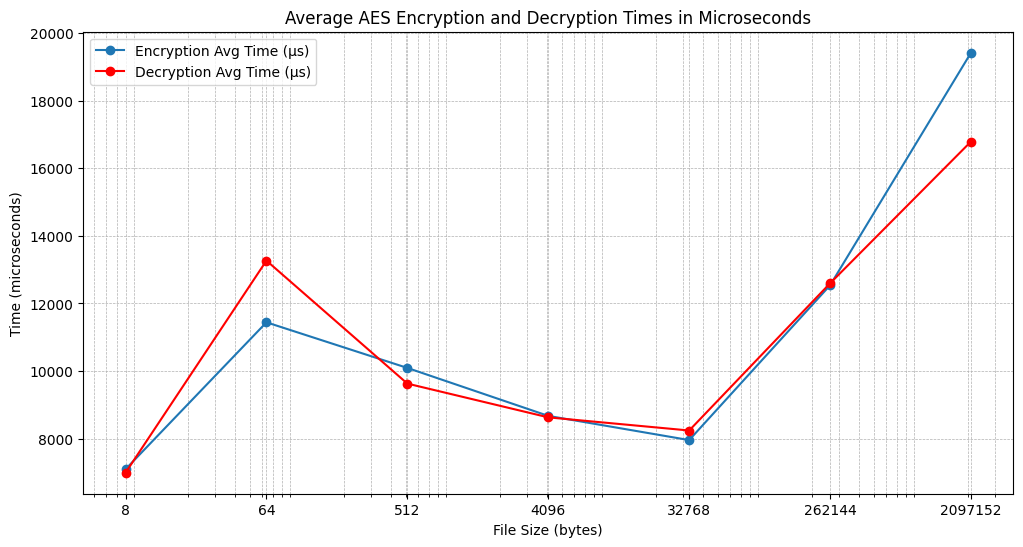

In [57]:
def Measure_Avg_AES_Multiple_Times(file_sizes_aes, num_files=15):
    encryption_times_avg = []
    decryption_times_avg = []
    key = os.urandom(32)
    iv = os.urandom(16)
    for size in file_sizes_aes:
        encryption_times = []
        decryption_times = []
        
        for i in range(num_files):
            input_file = f'aes_{size}_{i}.txt'
            encrypted_file = f'aes_{size}_{i}_encrypted.txt'
            
            # Measure encryption time
            encryption_time = timeit.timeit(lambda: encrypt_file_aes(input_file, encrypted_file, key,iv), number=1)
            encryption_times.append(encryption_time)
            
            # Measure decryption time
            decryption_time = timeit.timeit(lambda: decrypt_file_aes(encrypted_file, key, iv), number=1)
            decryption_times.append(decryption_time)

        encryption_times_avg.append(sum(encryption_times) / num_files)
        decryption_times_avg.append(sum(decryption_times) / num_files)
        
    # Plotting the results in microseconds
    plt.figure(figsize=(12, 6))

    # Convert average times from seconds to microseconds
    encryption_times_avg_us = [time * 1e6 for time in encryption_times_avg]
    decryption_times_avg_us = [time * 1e6 for time in decryption_times_avg]

    # Plotting
    plt.plot(file_sizes_aes, encryption_times_avg_us, '-o', label='Encryption Avg Time (µs)')
    plt.plot(file_sizes_aes, decryption_times_avg_us, '-o', label='Decryption Avg Time (µs)', color='red')

    # Updating labels
    plt.xlabel('File Size (bytes)')
    plt.ylabel('Time (microseconds)')

    # Keeping the x-axis logarithmic
    plt.xscale('log')
    plt.xticks(file_sizes_aes, labels=[str(size) for size in file_sizes_aes]) 

    # Updating title and legend
    plt.title('Average AES Encryption and Decryption Times in Microseconds')
    plt.legend()

    # Enabling grid for better readability
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Show the plot
    plt.show()

# Generate files
generate_multiple_files(file_sizes_aes,15)

# Now measure and plot
Measure_Avg_AES_Multiple_Times(file_sizes_aes)

-------------------------------------------------------------------------------------------------------------------------------------

C. Using the python module for RSA encryption and decryption, measure the time of RSA encryption and decryption
for the file sizes listed in part A, with a key of size 2048 bits (minimum recommended for RSA).

Encryption and Decryption times for RSA (in microseconds):

File size: 2 bytes, Encryption time: 54.33 microseconds, Decryption time: 907.33 microseconds
File size: 4 bytes, Encryption time: 42.24 microseconds, Decryption time: 1080.87 microseconds
File size: 8 bytes, Encryption time: 48.24 microseconds, Decryption time: 1336.94 microseconds
File size: 16 bytes, Encryption time: 69.54 microseconds, Decryption time: 920.87 microseconds
File size: 32 bytes, Encryption time: 46.45 microseconds, Decryption time: 802.62 microseconds
File size: 64 bytes, Encryption time: 65.78 microseconds, Decryption time: 842.97 microseconds
File size: 128 bytes, Encryption time: 68.17 microseconds, Decryption time: 914.13 microseconds


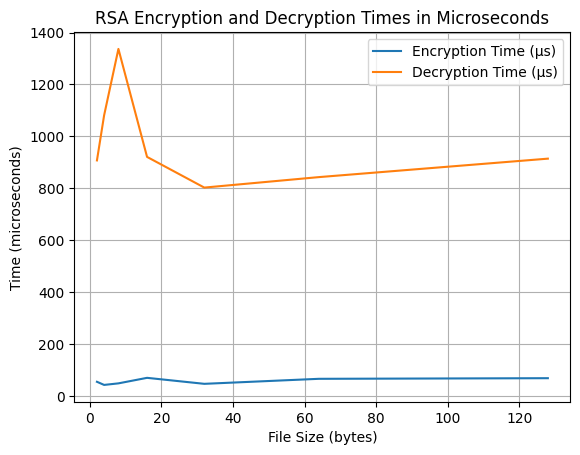

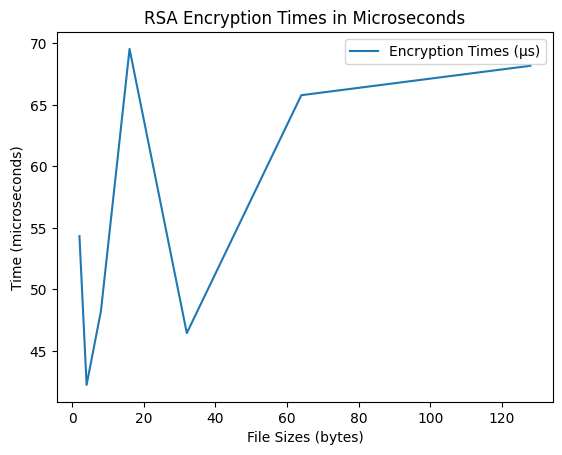

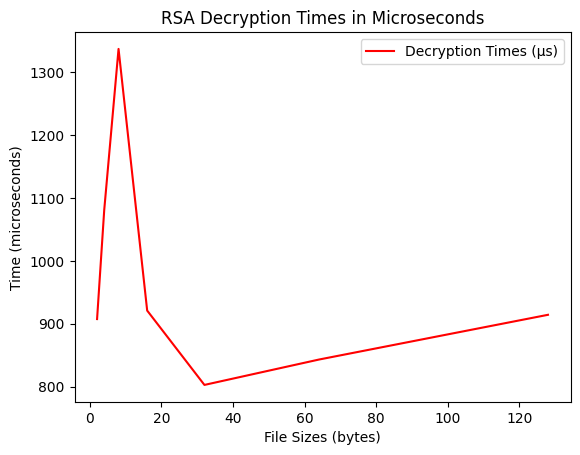

In [58]:
# Private and public keys for encryption/decryption
def generate_rsa_keys():
    private_key = rsa.generate_private_key(
        public_exponent=65537,
        key_size=2048,
        backend=default_backend()
    )
    public_key = private_key.public_key()
    return private_key, public_key

def rsa_encrypt(public_key, plaintext):
    encrypted = public_key.encrypt(
        plaintext,
        padding.PKCS1v15()
    )
    return encrypted

def rsa_decrypt(private_key, ciphertext):
    decrypted = private_key.decrypt(
        ciphertext,
        padding.PKCS1v15()
    )
    return decrypted

# Measure RSA encryption and decryption times for various file sizes
def measure_rsa_performance(file_sizes_rsa):
    private_key, public_key = generate_rsa_keys()
    encryption_times_us = []  # This will store times in microseconds
    decryption_times_us = []  # This will store times in microseconds
    for size in file_sizes_rsa:
        with open(f"rsa_{size}.txt", 'rb') as f:
            data = f.read()
        
        # Measure encryption time and convert to microseconds
        encryption_time = (timeit.timeit(lambda: rsa_encrypt(public_key, data), number=10) / 10) * 1e6
        encryption_times_us.append(encryption_time)
        
        # Encrypt the data for decryption measurement
        encrypted_data = rsa_encrypt(public_key, data)
        
        # Measure decryption time and convert to microseconds
        decryption_time = (timeit.timeit(lambda: rsa_decrypt(private_key, encrypted_data), number=10) / 10) * 1e6
        decryption_times_us.append(decryption_time)
        
        print(f"File size: {size} bytes, Encryption time: {encryption_time:.2f} microseconds, Decryption time: {decryption_time:.2f} microseconds")
    
    return encryption_times_us, decryption_times_us

print("Encryption and Decryption times for RSA (in microseconds):\n")

# Example file sizes
file_sizes_rsa = [2,4,8,16,32,64,128]

# Measure RSA performance
encryption_times_us, decryption_times_us = measure_rsa_performance(file_sizes_rsa)

# Plotting the results
plt.plot(file_sizes_rsa, encryption_times_us, label='Encryption Time (µs)')
plt.plot(file_sizes_rsa, decryption_times_us, label='Decryption Time (µs)')
plt.xlabel('File Size (bytes)')
plt.ylabel('Time (microseconds)')
plt.title('RSA Encryption and Decryption Times in Microseconds')
plt.legend()
plt.grid(True)
plt.show()

# Plot RSA encryption times
plt.plot(file_sizes_rsa, encryption_times_us, label='Encryption Times (µs)')
plt.xlabel('File Sizes (bytes)')
plt.ylabel('Time (microseconds)')
plt.title('RSA Encryption Times in Microseconds')
plt.legend()
plt.show()

# Plot RSA decryption times
plt.plot(file_sizes_rsa, decryption_times_us, label='Decryption Times (µs)', color='red')
plt.xlabel('File Sizes (bytes)')
plt.ylabel('Time (microseconds)')
plt.title('RSA Decryption Times in Microseconds')
plt.legend()
plt.show()


-------------------------------------------------------------------------------------------------------------------------------------

D. Measure the time for SHA-256 hash generation for the file sizes listed in part a.

SHA digest generation times:

File size: 8 bytes; SHA-256 hash generation time: 0.000005 seconds
File size: 64 bytes; SHA-256 hash generation time: 0.000006 seconds
File size: 512 bytes; SHA-256 hash generation time: 0.000007 seconds
File size: 4096 bytes; SHA-256 hash generation time: 0.000028 seconds
File size: 32768 bytes; SHA-256 hash generation time: 0.000143 seconds
File size: 262144 bytes; SHA-256 hash generation time: 0.000795 seconds
File size: 2097152 bytes; SHA-256 hash generation time: 0.006209 seconds


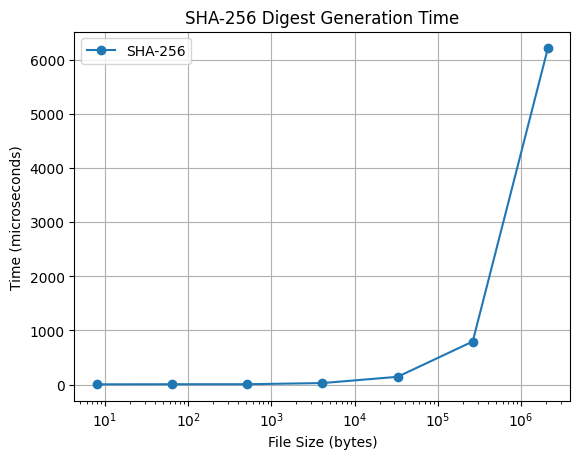

In [66]:
# Function to generate a SHA-256 hash of the data
def sha256_hash(input_file):
    sha256 = hashlib.sha256()
    sha256.update(input_file)
    return sha256.hexdigest()

# Measure the time for SHA-256 hash generation for various file sizes
def measure_sha256_performance(file_sizes_sha):
    hash_times = []
    for size in file_sizes_sha:
        with open(f"sha_{size}.txt", 'rb') as f:
            data = f.read()
        
        # Measure hash generation time
        hash_time = timeit.timeit(lambda: sha256_hash(data), number=10) / 10
        hash_times.append(hash_time)
        
        print(f"File size: {size} bytes; SHA-256 hash generation time: {hash_time:.6f} seconds")
    return hash_times

print("SHA digest generation times:\n")

# Measure and print SHA-256 performance
hash_times = measure_sha256_performance(file_sizes_sha)

# Plotting the results
plt.plot(file_sizes_sha, [time * 1e6 for time in hash_times], marker='o', label='SHA-256')
plt.xlabel('File Size (bytes)')
plt.ylabel('Time (microseconds)')
plt.title('SHA-256 Digest Generation Time')
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.show()

-------------------------------------------------------------------------------------------------------------------------------------

E. Prepare a report of your observations, including the following information:
- Code implemented for points b., c., and d. above
- Brief explanation of the main components of the code (the rest should be submitted in a separate compressed
file)
- Explain how you generated/obtained the results – must be statistically significant. This must include a
description of the experimental setup (e.g. computer characteristics, OS, software versions).
- Plots showing: (i) AES encryption/decryption times; (ii) RSA encryption times; (iii) RSA decryption times;
and (iv) SHA digests generation times (plots can be combined for easier comparison). In these graphs, the
X axis should plot the file sizes in units of bytes, and the Y axis should plot time measurements in units of
microseconds (us).
1
- The report should also analyze and explain the performance results of:
    - Comparison between AES encryption and RSA encryption.
    - Comparison between AES encryption and SHA digest generation.
    - Comparison between RSA encryption and decryption times.

Let's compare AES encryption and RSA encryption



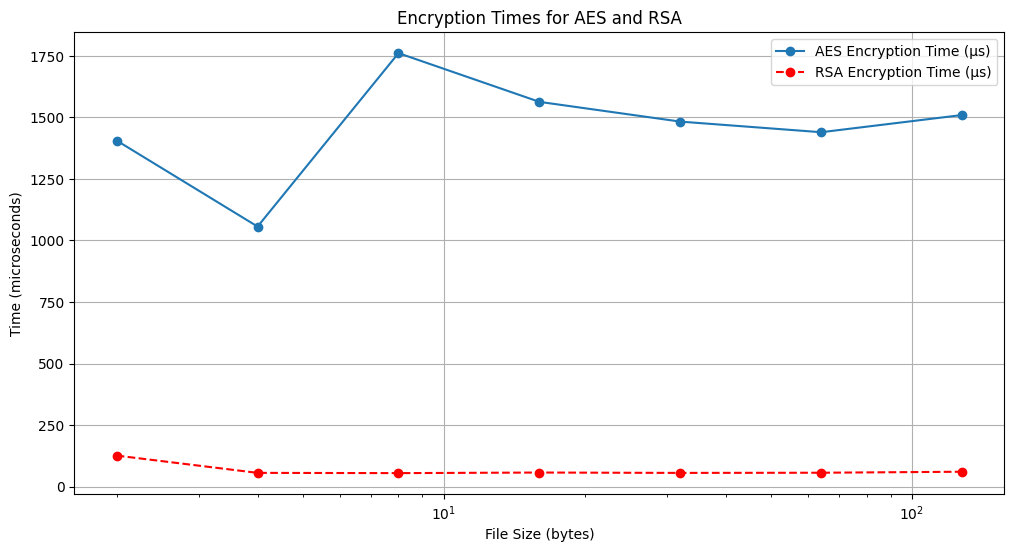

In [61]:
# Function to measure and compare encryption times
def measure_encryption_times(file_sizes_aes, file_sizes_rsa):
    private_key, public_key = generate_rsa_keys()
    aes_key = os.urandom(32)
    aes_iv = os.urandom(16)

    aes_encryption_times = []
    for size in file_sizes_aes:
        data = os.urandom(size)
        # Write data to a temporary file
        with open('temp_input_file', 'wb') as temp_file:
            temp_file.write(data)
        # Measure AES encryption time
        encryption_time_aes = timeit.timeit(lambda: encrypt_file_aes('temp_input_file', 'temp_aes_encrypted', aes_key, aes_iv), number=10) / 10
        aes_encryption_times.append(encryption_time_aes)

    rsa_encryption_times = []
    for size in file_sizes_rsa:
        data = os.urandom(size)
        # Measure RSA encryption time directly since it works with data
        encryption_time_rsa = timeit.timeit(lambda: rsa_encrypt(public_key, data), number=10) / 10
        rsa_encryption_times.append(encryption_time_rsa)

    # Cleanup temporary files if necessary
    os.remove('temp_input_file')
    os.remove('temp_aes_encrypted')

    return aes_encryption_times, rsa_encryption_times

# Your file sizes
file_sizes_aes = [2, 4, 8, 16, 32, 64, 128]
file_sizes_rsa = [2, 4, 8, 16, 32, 64, 128]

# Perform the measurements
aes_encryption_times, rsa_encryption_times = measure_encryption_times(file_sizes_aes, file_sizes_rsa)

# Convert times to microseconds for plotting
aes_encryption_times_us = [time * 1e6 for time in aes_encryption_times]
rsa_encryption_times_us = [time * 1e6 for time in rsa_encryption_times]

# Plotting AES encryption times
plt.figure(figsize=(12, 6))
plt.plot(file_sizes_aes, aes_encryption_times_us, label='AES Encryption Time (µs)', marker='o')
plt.xscale('log')
plt.xlabel('File Size (bytes)')
plt.ylabel('Time (microseconds)')
plt.title('Encryption Times for AES and RSA')
plt.legend()
plt.grid(True)

# Plotting RSA encryption times
plt.plot(file_sizes_rsa, rsa_encryption_times_us, label='RSA Encryption Time (µs)', marker='o', linestyle='--', color='red')
plt.xscale('log')
plt.xlabel('File Size (bytes)')
plt.ylabel('Time (microseconds)')
plt.legend()
plt.grid(True)

plt.show()

TEORIA


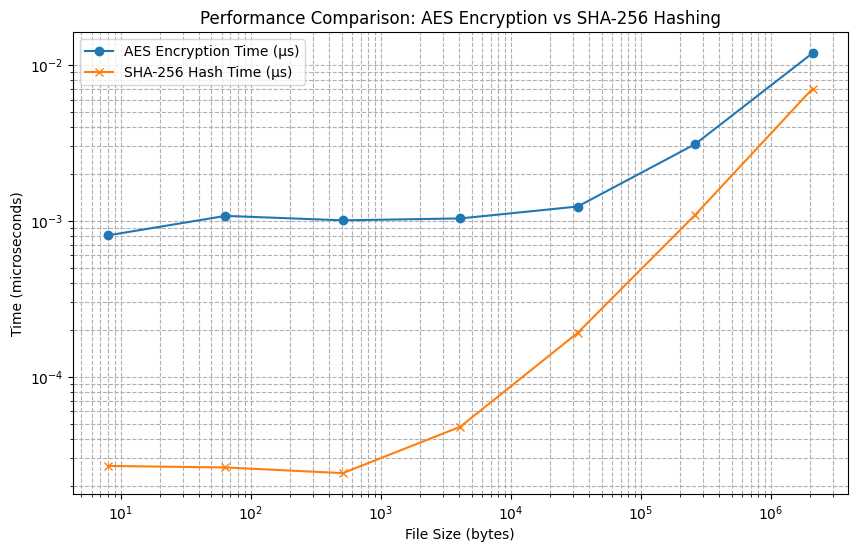

In [72]:
def measure_performance(file_sizes):
    aes_encryption_times = []
    sha256_hash_times = []
    
    aes_key = os.urandom(32)
    aes_iv = os.urandom(16)

    for size in file_sizes_sha:
        input_file = f"aes_{size}.txt"
        with open(f"aes_{size}.txt", 'rb') as f:
            data = f.read()
        
        # Measure AES encryption time
        start_time = timeit.default_timer()
        encrypt_file_aes(input_file, 'temp_aes_encrypt' , aes_key, aes_iv)  # Adjusted to directly use data
        aes_time = timeit.default_timer() - start_time
        aes_encryption_times.append(aes_time)
        
        # Measure SHA-256 hash generation time
        start_time = timeit.default_timer()
        sha256_hash(data)
        sha_time = timeit.default_timer() - start_time
        sha256_hash_times.append(sha_time)

        os.remove('temp_aes_encrypt')
        
    
    return aes_encryption_times, sha256_hash_times


file_sizes_aes = [8, 64, 512, 4096, 32768, 262144, 2097152]
aes_times, sha_times = measure_performance(file_sizes_aes)


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(file_sizes_aes, aes_times, '-o', label='AES Encryption Time (µs)')
plt.plot(file_sizes_aes, sha_times, '-x', label='SHA-256 Hash Time (µs)')

# Using a logarithmic scale for x-axis to accommodate the wide range of file sizes
plt.xscale('log')
plt.yscale('log')
plt.xlabel('File Size (bytes)')
plt.ylabel('Time (microseconds)')
plt.title('Performance Comparison: AES Encryption vs SHA-256 Hashing')
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.show()